In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
# import seaborn as sns

from sklearn import linear_model

Parameters

In [2]:
M = 50
N = 100000

S0 = 100.0
K = 105.0


r = 0.10
sigma = 0.2
T = 1.0
dt = T / M
df = np.exp(-r * dt)

### Geometric Brownian Motion (GBM) diffusion

Simulating Geometric Brownian Motion
The Black-Scholes-Merton model is given by the SDE:

$$
dS_t = rS_tdt + \sigma S_t dZ_t
$$
$S_t$ is the stock price at time $t$, $r$ is the constant risk-less short rate, $\sigma$ the constant volatility factor and $Z_t$ a standard Brownian motion.

An Euler discretization of the model for MCS is given by:

$$
S_t = S_{t-\Delta t} \cdot \exp \left(\left(r - \frac{\sigma^2}{2}\right)\Delta t + \sigma \sqrt{\Delta t} z_t\right)
$$
Here, $\Delta t = \frac{T}{M}$ (with $T$ being the time horizon) is the discrete, homogenous time interval and $z_t$ is a standard normally distributed rv.

In [3]:
def generate_random_numbers(M, N):
    np.random.seed(1)
    random_numbers = np.random.standard_normal((M+1, N))
    random_numbers -= random_numbers.mean()
    random_numbers /= random_numbers.std()
    return random_numbers

In [4]:
def gbm_stock_price_paths(M, N):
    random_numbers = generate_random_numbers(M, N)
    random_numbers[0] = 0.0
    S = np.zeros_like(random_numbers)
    S = S0 * np.exp(((r - 0.5 * sigma ** 2) * dt + sigma * dt ** 0.5 * random_numbers).cumsum(axis=0))
    S[0] = S0 # ?
    return S

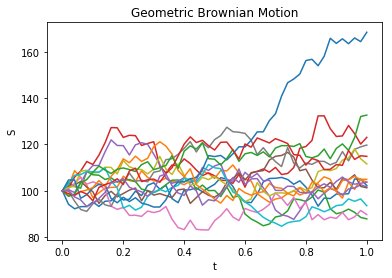

In [5]:
S = gbm_stock_price_paths(M, N)

plt.plot([i*dt for i in range(M+1)], S[:, :15])
plt.xlabel('t')
plt.ylabel('S')
plt.title('Geometric Brownian Motion')
plt.show()

In [6]:
%time 
for _ in range(5):
    S = gbm_stock_price_paths(M, N)

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 5.96 µs


Heston diffusion

In [7]:
pass

In [8]:
pass

Longstaff Schwartz

In [9]:
def Longstaff_Schwarz_methon(M, N, stock_price_mc_diffusion_function=gbm_stock_price_paths,
                             option_type='put', order=5):
    S = stock_price_mc_diffusion_function(M, N)
    
    # intrinsic value
    if option_type == 'put':
        h = np.maximum(K - S, 0)
    elif option_type == 'call':
        h = np.maximum(S - K, 0)
    else:
        raise Exception('Option type is unknown.')
        
    V = h[-1]
    for t in range(M-1, 0, -1):
        reg = np.polyfit(S[t], V * df, deg=order)
        C = np.polyval(reg, S[t])
        V = np.where(h[t] > C, h[t], V * df)
    return V, V.mean() * df

In [10]:
_, P0 = Longstaff_Schwarz_methon(M, N)
P0

7.117308388919767

In [11]:
%time
for _ in range(5):
    V, P0 = Longstaff_Schwarz_methon(M, N)
    print(P0)

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 5.25 µs
7.11730838892
7.11730838892
7.11730838892
7.11730838892
7.11730838892


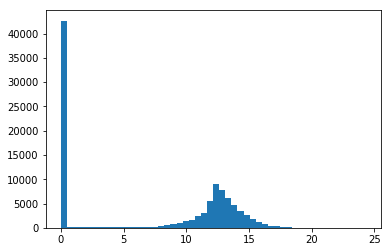

In [12]:
plt.hist(V, bins=50)
plt.show()

Logistic Regression

In [13]:
def sk_log_regression_Longstaff_Schwartz(M, N, stock_price_mc_diffusion_function=gbm_stock_price_paths,
        option_type='put', order=5):
    S = stock_price_mc_diffusion_function(M, N)
    
    # later we can optimize the hype parameter C
    
    logistic_reg = linear_model.LogisticRegression(C=1.0)

    # intrinsic value
    if option_type == 'put':
        h = np.maximum(K - S, 0)
    elif otype == 'call':
        h = np.maximum(S - K, 0)
    else:
        raise Exception('Option type is unknown.')
        
    def create_regressors(deg=5):
        l = [h[t]]
        for o in range(1, deg+1):
            l.append(S[t] ** o)
            l.append(S[t-1] ** o)
        return np.array(l).T
    
    V = h[-1]
    
    for t in range(M-1, 0, -1):
        worth_to_exercise = (h[t] > V * df).astype(int)
        X = create_regressors(deg=order)
        logistic_reg.fit(X, worth_to_exercise)
        exercise = logistic_reg.predict(X)
        V = np.where(exercise, h[t], V * df)
    return V, df * V.mean()

In [14]:
%%time
for _ in range(5):
    V, P0 = sk_log_regression_Longstaff_Schwartz(M, N)
    print(P0)

7.17720046817
7.17720046817
7.17720046817
7.17720046817
7.17720046817
CPU times: user 3min 2s, sys: 1.96 s, total: 3min 4s
Wall time: 2min 16s


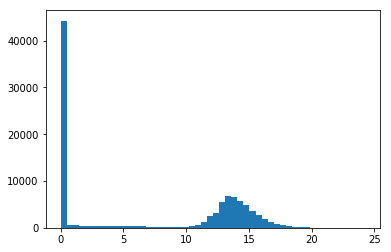

In [15]:
plt.hist(V, bins=50)
plt.show()

In [16]:
# plt.hist(V, bins=35)
# plt.show()

# sns.distplot(V, bins=50)
# plt.show()

In [ ]:
# sns.kdeplot(V, shade=True, cut=0)
# sns.rugplot(V);
# plt.show()